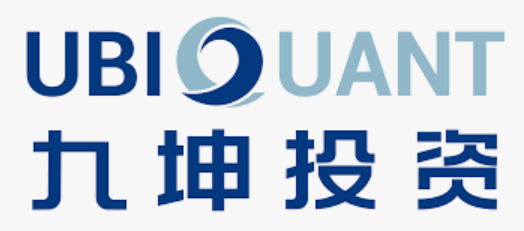

# Stacking & Feature Importances

@marketneutral

This is my third Ubiquant competition notebook. Please also see my other three notebooks.

- ["Ubiquant Target EDA PCA Magic"](https://www.kaggle.com/marketneutral/ubiquant-target-eda-pca-magic)
- ["Ubiquant Feature Exploration"](https://www.kaggle.com/marketneutral/ubiquant-feature-exploration)
- ["Robust Multi-Target PyTorch"](https://www.kaggle.com/marketneutral/robust-multi-target-pytorch)

# Updated!
Version Notes

- (1) Version 4 released Feb 14, 2022 ❤️
- (2) Version 6 released Feb 15, 2022
    - changed split importance to `gain`
    - added plotly scatter to visualize rank autocorr vs pearson corr
    - reduced train size to last 1mm rows to avoid OOM
    - added per sample cross features
    - added LGB importance as size in plot
    - made signs consistent for raw features in train (positive --> higher target)
- (3) Version 8 released Feb 15, 2022
    - added submission
- (4) Version 9 March 13, 2022
    - changed cutoffs for slow/mid/fast per comment from [PlaDJ](https://www.kaggle.com/denisplaj).

<div class="alert alert-warning">
<b>TL;DR:</b> We take the feature rank autocorrelations generated in the previous notebook and make features from them. We binarize the target and fit a logistic regression on subsets of features as a function of their speed. We get the out-of-fold predictions and feed these into LightGBM. LightGBM feature importance shows that these features are very informative. 
</div>

In [ ]:
import gc, time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

import lightgbm as lgb

from tqdm.notebook import tqdm
from sklearn.linear_model import LogisticRegression
from sklearn.base import clone
from sklearn.metrics import (
    roc_auc_score,
    mean_squared_error
)
from sklearn.model_selection import (
    TimeSeriesSplit
)

plt.rcParams['figure.figsize'] = (16, 5)

import warnings
warnings.filterwarnings("ignore")

# Load and Inspect the Data

Thanks [Rob Mulla](https://www.kaggle.com/robikscube) for the reduced memory version of the data.

In [ ]:
%%time
train = (pd.read_parquet('../input/ubiquant-parquet/train_low_mem.parquet')
         .sort_values(['time_id', 'investment_id'])
         .drop(columns=['row_id'])
         [-1000000: ]
         .reset_index(drop=True));

gc.collect()

In [ ]:
train.head()

Read in label feature (from first notebook) and feature-rank-autocorrelations (second notebook).

In [ ]:
label = (pd.read_csv('../input/ubiquant-labels/label_feature.csv')
         .rename(columns={'label_feature': 'f_label_feature'}))
label['f_label_feature'] = label['f_label_feature'] + 1
label = label.astype(np.uint16)

In [ ]:
# train = train.merge(label, on='investment_id')
# train[['f_label_feature']] = train[['f_label_feature']].fillna(0)

In [ ]:
gc.collect()

In [ ]:
corr = pd.read_csv('../input/ubiquant-fra-and-corr/corr.csv', index_col=0)
fra = pd.read_csv('../input/ubiquant-fra-and-corr/fra.csv', index_col=0)

In [ ]:
corr.min()

In [ ]:
corr

In [ ]:
# %%time
# for i, row in (corr < 0).reset_index().iterrows():
#     if row['corr'] == True:
#         train[row[0]] = -train[row[0]]

In [ ]:
fra.head()

# Make Per Sample Cross Features

In [ ]:
#https://www.kaggle.com/lucamassaron/basic-eda-and-model-to-start



def feature_engineering(df, features):
    
    df['f_mean'] = df[features].mean(axis=1)
    df['f_median'] = df[features].median(axis=1)
    df['f_q01'] = df[features].quantile(q=0.01, axis=1)
    df['f_q05'] = df[features].quantile(q=0.05, axis=1)
    df['f_q10'] = df[features].quantile(q=0.10, axis=1)
    df['f_q25'] = df[features].quantile(q=0.25, axis=1)
    df['f_q75'] = df[features].quantile(q=0.75, axis=1)
    df['f_q90'] = df[features].quantile(q=0.90, axis=1)
    df['f_q95'] = df[features].quantile(q=0.95, axis=1)
    df['f_q99'] = df[features].quantile(q=0.99, axis=1)
    df['f_max'] = df[features].max(axis=1)
    df['f_min'] = df[features].min(axis=1)
    
    df['f_std'] = df[features].std(axis=1)
    df['f_range'] = df['f_max'] - df['f_min']
    df['f_iqr'] = df['f_q75'] - df['f_q25']
    df['f_tails'] = df['f_range'] / df['f_iqr']
    df['f_dispersion'] = df['f_std'] / df['f_mean']
    df['f_dispersion_2'] = df['f_iqr'] / df['f_median']
    df['f_skew'] = df[features].skew(axis=1)
    df['f_kurt'] = df[features].kurt(axis=1)
    
    df['f_median-max'] = df['f_median'] - df['f_max']
    df['f_median-min'] = df['f_median'] - df['f_min']
    df['f_q99-q95'] = df['f_q99'] - df['f_q95']
    df['f_q99-q90'] = df['f_q99'] - df['f_q90']
    df['f_q01-q05'] = df['f_q01'] - df['f_q05']
    df['f_q01-q10'] =  df['f_q01'] - df['f_q10']
    
    gc.collect()
    
    return df

In the previous version of this notebook, I show that these cross features are not useful. 

In [ ]:
%%time
# feats = [f for f in train.columns if f not in ['time_id', 'row_id', 'target']]
# train = feature_engineering(train, feats)

# Make Speed Features

In [ ]:
fra['fast'] = fra['fra'] < 0.85
fra['mid'] = (fra['fra'] >= 0.85) & (fra['fra'] < 0.98)
fra['slow'] = fra['fra'] >= 0.98

slow_features = (fra.query('slow == True')).index.to_list()
mid_features = (fra.query('mid == True')).index.to_list()
fast_features = (fra.query('fast == True')).index.to_list()

# Fit LogReg with Feature Subsets

In [ ]:
target_binary = (train['target'] > 0).astype(int)

In [ ]:
lr = LogisticRegression(C = 0.001, verbose=False, n_jobs=1)

We need out-of-fold predictions to stack into LightGBM (if we don't use OOF, then LGB will massively overfit). `sklearn` version of `cross_val_predict` does not handle time series. So, we write our own here.

In [ ]:
def timeseries_cross_val_predict(estimator, X, y, cv):
    """We have to write our own cross_val_predict because the one
    that is in sklearn does not work for time series"""
    oof_pred = y.copy()
    oof_pred.iloc[:] = np.nan
    scores = []
    fit_scores = []
    estimators = []
    
    for train_idx, valid_idx in tqdm(cv.split(X), total=N_SPLITS):
        this_estimator = clone(estimator)
        this_estimator.fit(X.iloc[train_idx], y.iloc[train_idx])
        
        estimators.append(this_estimator)
        
        oof_pred.iloc[valid_idx] = (
            this_estimator.predict_proba(X.iloc[valid_idx])[:, 1]
        )
        
        in_fold_pred = this_estimator.predict_proba(X.iloc[train_idx])[:, 1]
        
        score = roc_auc_score(
            y.iloc[valid_idx],
            (oof_pred.iloc[valid_idx] > 0.5).astype(int)
        )
        
        fit_score = roc_auc_score(
            y.iloc[train_idx],
            (in_fold_pred > 0.5).astype(int)
        )
        
        scores.append(score)
        fit_scores.append(fit_score)
        
    return oof_pred, scores, fit_scores, estimators

In [ ]:
gc.collect()

In [ ]:
N_SPLITS = 5

tscv = TimeSeriesSplit(n_splits=N_SPLITS, max_train_size=3000*260)
slow_oof_pred, slow_auc, slow_in_auc, slow_log_regs = timeseries_cross_val_predict(
    lr,
    train[slow_features],
    target_binary,
    tscv
)

gc.collect()

tscv = TimeSeriesSplit(n_splits=N_SPLITS, max_train_size=3000*260)
mid_oof_pred, mid_auc, mid_in_auc, mid_log_regs = timeseries_cross_val_predict(
    lr,
    train[mid_features],
    target_binary,
    tscv
)

gc.collect()

tscv = TimeSeriesSplit(n_splits=N_SPLITS, max_train_size=3000*260)
fast_oof_pred, fast_auc, fast_in_auc, fast_log_regs = timeseries_cross_val_predict(
    lr,
    train[fast_features],
    target_binary,
    tscv
)

gc.collect()

In [ ]:
# we have the fitted models for prediction later
slow_log_regs

Add the out-of-fold predictions to the training set.

In [ ]:
train['f_slow_logreg'] = slow_oof_pred
train['f_mid_logreg'] = mid_oof_pred
train['f_fast_logreg'] = fast_oof_pred

In [ ]:
all_columns = train.columns
features = all_columns[train.columns.str.contains('f_')].to_list()

# Train LGB and Inspect Feature Importance

This is a helper function which trains each fold, keeps track of feature importance, and plots feature importance (with error bars).

In [ ]:
# based on source https://www.kaggle.com/artgor/dota-eda-fe-and-models

def train_model(
    X,
    y,
    params,
    cv,
    score_func,
    plot_feature_importance=False,
    cat_features=[],
    importance_type='gain'
):

    oof = np.zeros(len(X))
    scores = []
    feature_importance = pd.DataFrame()
    models = []
    
    for fold_n, (train_index, valid_index) in enumerate(cv.split(X)):
        print('Fold', fold_n+1, 'started at', time.ctime())
        X_train, X_valid = X.loc[train_index], X.loc[valid_index]
        y_train, y_valid = y[train_index], y[valid_index]
        
        train_data = lgb.Dataset(X_train, label=y_train)
        valid_data = lgb.Dataset(X_valid, label=y_valid)

        model = lgb.train(
            params=params,
            train_set=train_data,
            num_boost_round=2000,
            valid_sets=[
                train_data,
                valid_data
            ],
            callbacks=[
                lgb.early_stopping(stopping_rounds=200),
                lgb.log_evaluation(period=200)
            ],
            categorical_feature = \
                cat_features if len(cat_features) > 0 else 'auto'
        )
        
        models.append(model)

        y_pred_valid = model.predict(X_valid)

        oof[valid_index] = y_pred_valid.reshape(-1,)
        scores.append(score_func(y_valid, y_pred_valid))

        fold_importance = pd.DataFrame()
        fold_importance["feature"] = X.columns
        fold_importance["importance"] = model.feature_importance(importance_type)
        fold_importance["fold"] = fold_n + 1
        feature_importance = \
            pd.concat([feature_importance, fold_importance], axis=0)

    print('CV mean score: {0:.4f}, std: {1:.4f}.'.format(np.mean(scores),
                                                         np.std(scores)))
    
    feature_importance["importance"] /= (fold_n + 1)

    if plot_feature_importance:
        cols = (feature_importance[["feature", "importance"]]
                  .groupby("feature")
                  .mean()
                  .sort_values(by="importance", ascending=False)[:100].index)

        best_features = feature_importance.loc[feature_importance.feature.isin(cols)]

        plt.figure(figsize=(16, 20));
        sns.barplot(
            x="importance",
            y="feature",
            data=best_features.sort_values(by="importance", ascending=False));
        plt.title(f'LGBM Feature Importances (avgerage over folds): {importance_type}');
        
        return oof, scores, feature_importance, models
    else:
        return oof, scores, models


In [ ]:
params = {
    'feature_fraction': 0.85,
    'bagging_fraction': 0.85,
    'learning_rate': 0.075,
    'max_depth': -1,
    'min_data_in_leaf': 500,
    'num_threads': -1,
    'verbosity': -1,
    'objective': "regression"
}

In [ ]:
tscv = TimeSeriesSplit(n_splits=N_SPLITS, max_train_size=3000*260)

In [ ]:
%%time
oof, scores, feature_imp, lgb_models = train_model(
    train.dropna()[features].reset_index(drop=True),
    train.dropna()['target'].reset_index(drop=True),
    params=params,
    cv=tscv,
    plot_feature_importance=True,
    score_func=mean_squared_error
)

We can see that the linear up/down predictor for the **fast** features is very **important**. This should make a good feature in this competition.


In [ ]:
df = (corr
      .join(fra)
      .sort_values('corr_abs')
      .reset_index()
      .merge(feature_imp.groupby('feature')[['importance']]
                        .mean()
                        .reset_index(),
             how='left', left_on='index', right_on='feature')
      .assign(imp_amp = lambda x: (np.square(x.importance))))

fig = px.scatter(
    df,
    x="fra",
    y="corr_abs",
    opacity=0.35,
    trendline="ols",
    text='index',
    title='Feature Rank Autocorr vs Feature:Target Pearson Corr (size=LGBM Importance (gain))',
    size='imp_amp',
    width=900,
    height=900
)

fig.show()

It's interesting that there are many features that have high gain importance, but have very low Pearson corr with the target.

Things to take away from this Notebook: 1) the `label_feature` is not informative; 2) the per sample cross features are not informative; 3) the stacking features are very informative.

# Prediction Time!

In [ ]:
%%time

import ubiquant

env = ubiquant.make_env()   # initialize the environment
iter_test = env.iter_test()    # an iterator which loops over the test set and sample submission

for (test_df, sample_prediction_df) in iter_test:
    
    # initialize columns
    test_df['target']  = 0
    test_df['f_slow_logreg'] = 0
    test_df['f_mid_logreg'] = 0
    test_df['f_fast_logreg'] = 0
    
    for i, mod in enumerate(lgb_models):
        test_df['f_slow_logreg'] = slow_log_regs[i].predict(test_df[slow_features])
        test_df['f_mid_logreg'] = mid_log_regs[i].predict(test_df[mid_features])
        test_df['f_fast_logreg'] = fast_log_regs[i].predict(test_df[fast_features])     
        test_df['target'] += mod.predict(test_df[features])
    
    test_df['target'] /= len(lgb_models)
    env.predict(test_df[['row_id','target']])

Thank you for taking a look at this notebook. Please leave comments and suggestions.